# Natural Language Processing with Disaster Tweets

## Description

In this competition, it is required to create a machine learning model that predicts which tweets are dedicated to real disasters and which are not.

## Loading data

In [121]:
!pip install pathlib==1.0.1 -q

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [123]:
# define the variables
DIR='./data'

In [124]:
df = pd.read_csv(f'{DIR}/train.csv', index_col='id')

df.info()

df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7613 entries, 1 to 10873
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   7552 non-null   object
 1   location  5080 non-null   object
 2   text      7613 non-null   object
 3   target    7613 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 297.4+ KB


,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


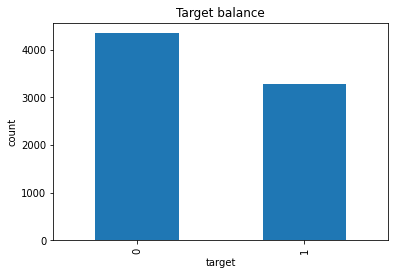

In [125]:
#balance
df['target'].value_counts().plot(kind='bar')
plt.title('Target balance')
plt.ylabel('count')
plt.xlabel('target')
plt.show()

__Note__: no significant imbalance found

### Location

In [126]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [127]:
# let's check the uniqueness
df['location'].nunique()

3341

In [128]:
df['location'] = df['location'].fillna('unknown')

In [129]:
def get_word_count(txt):
    """
    Calculating the number of words
    
    Inputs:
    -----------
    txt: string - input text
    
    Outputs:
    --------
    integer - word lengths
    """
    txt = txt.lower()
    word_tokens = word_tokenize(txt)
    
    return len(word_tokens)

df['location_word_count'] = df['location'].apply(get_word_count)

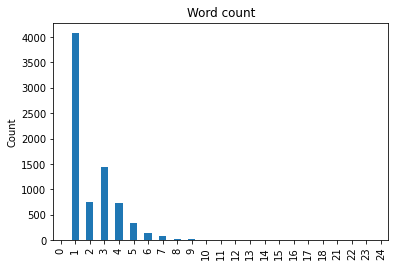

In [130]:
dfc = df['location_word_count'].value_counts()
dfc.sort_index(inplace=True)
dfc.plot(kind='bar')
plt.title('Word count')
plt.ylabel('Count')
plt.xlabel('')
plt.show()

#### Loading intermediate data

In [131]:
# https://unece.org/trade/cefact/UNLOCODE-Download
division_code_df = pd.read_csv(f'{DIR}/2023-1 SubdivisionCodes.csv', names=['Country', 'City', 'Name', 'Type'])

division_code_df.head()

,Country,City,Name,Type
0,AD,02,Canillo,Parish
1,AD,03,Encamp,Parish
2,AD,04,La Massana,Parish
3,AD,05,Ordino,Parish
4,AD,06,Sant Juliа de Lтria,Parish


In [132]:
# get city names
names = list(division_code_df['Name'].str.lower())

In [133]:
country_df = pd.read_csv(f'{DIR}/country-list_data.csv')

country_df.head()

,Name,Code
0,Afghanistan,AF
1,Åland Islands,AX
2,Albania,AL
3,Algeria,DZ
4,American Samoa,AS


In [134]:
countries = list(country_df['Name'].str.lower())

#### Preprocessing

In [135]:
def is_country(txt):
    txt = txt.lower()
    
    for country in countries:
        if country in txt:
            return True
    
    return False

df['isCountry'] = df['location'].apply(is_country)

In [136]:
def is_city(txt):
    txt = txt.lower()
    
    for name in names:
        if name in txt:
            return True
    
    return False

df['isCity'] = df['location'].apply(is_city)

In [137]:
df['isUnknown'] = df['location'] == 'unknown'

In [138]:
df['isOther'] = (df['isCity'] == False) & (df['isCountry'] == False) & (df['isUnknown'] == False)

### Keyword

In [139]:
df['keyword'] = df['keyword'].fillna('unknown')

In [140]:
df['keyword'].nunique()

222

In [141]:

df['keyword_word_count'] = df['keyword'].apply(lambda x: len(x.lower().split('%20')))

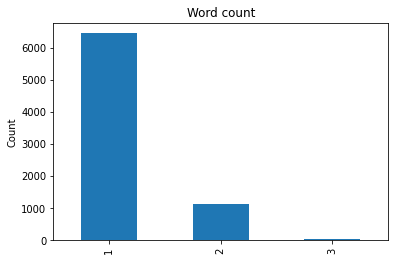

In [142]:
dfc = df['keyword_word_count'].value_counts()
dfc.sort_index(inplace=True)
dfc.plot(kind='bar')
plt.title('Word count')
plt.ylabel('Count')
plt.xlabel('')
plt.show()

In [143]:
df[df['keyword_word_count'] > 2].head()

,keyword,location,text,target,location_word_count,isCountry,isCity,isUnknown,isOther,keyword_word_count
id,,,,,,,,,,
1771,buildings%20on%20fire,World Wide,Fire hazard associated with installation of no...,1,2,False,False,False,True,3
1772,buildings%20on%20fire,Intermountain West,.@greenbuildermag @NFPA to hold free webinar o...,1,2,False,True,False,False,3
1773,buildings%20on%20fire,World Wide,Fire hazard associated with installation of no...,0,2,False,False,False,True,3
1774,buildings%20on%20fire,New Hampshire,Video: Fire burns two apartment buildings and...,1,2,False,True,False,False,3
1775,buildings%20on%20fire,"Manchester, NH",Fire destroys two buildings on 2nd Street in #...,1,3,False,True,False,False,3


In [144]:
# get unique keywords
keywords = []

def iter_keyword(txt):
    txt = txt.lower()
    word_tokens = txt.split('%20')
    
    if len(word_tokens) == 3:
        keywords.append(txt.replace('%20', ' '))
    else:      
        for word in word_tokens:
            keywords.append(word)

df['keyword'].apply(iter_keyword)

keywords = list(set(keywords))

In [145]:
df.loc[:, keywords] = np.zeros((len(keywords)), dtype=int)

In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7613 entries, 1 to 10873
Columns: 240 entries, keyword to bag
dtypes: bool(4), int32(230), int64(3), object(3)
memory usage: 7.1+ MB


In [147]:
df.head()

,keyword,location,text,target,location_word_count,isCountry,isCity,isUnknown,isOther,keyword_word_count,...,first,derailed,rescue,rainstorm,hostages,bomb,hurricane,hostage,drought,bag
id,,,,,,,,,,,,,,,,,,,,,
1,unknown,unknown,Our Deeds are the Reason of this #earthquake M...,1,1,False,False,True,False,1,...,0,0,0,0,0,0,0,0,0,0
4,unknown,unknown,Forest fire near La Ronge Sask. Canada,1,1,False,False,True,False,1,...,0,0,0,0,0,0,0,0,0,0
5,unknown,unknown,All residents asked to 'shelter in place' are ...,1,1,False,False,True,False,1,...,0,0,0,0,0,0,0,0,0,0
6,unknown,unknown,"13,000 people receive #wildfires evacuation or...",1,1,False,False,True,False,1,...,0,0,0,0,0,0,0,0,0,0
7,unknown,unknown,Just got sent this photo from Ruby #Alaska as ...,1,1,False,False,True,False,1,...,0,0,0,0,0,0,0,0,0,0
